# Image recognition

> Written by Dr Daniel Buscombe, Northern Arizona University

> Part of a series of notebooks for image recognition and classification using deep convolutional neural networks

This notebook demonstrates some strategies for image recognition using common machine learning techniques

Load in some libraries

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import s3fs
fs = s3fs.S3FileSystem(anon=True)

root = 'esipfed/cdi-workshop'

![](http://www.bogotobogo.com/python/scikit-learn/images/features/FeatureExtraction.png)

### Preparing the dataset

We'll work with a dataset consisting of images of sandbars in Grand Canyon

In [2]:
frames = [f for f in fs.ls(root+'/semseg_data/sandbars') if f.endswith('.JPG')]
# all files in <directory> which end in '.jpg' store in frames

In [3]:
print('We have %i images' % len(frames))

We have 51 images


In [4]:
## import some image reading/resizing functions
from scipy.misc import imresize
from imageio import imread

Read in the images into an array, downsizing by an eigth

In [5]:
examples = [] # create an empty list in the memory
for file in frames: # for all items in the list frames
    with fs.open(file, 'rb') as f: # use the .open() method (readbyte=rb) on files and store as 'f'
        examples.append(imresize(imread(f), .125)) # resize files stored in 'f', and append them into the empty list called examples

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Check the size of the images

In [6]:
nx, ny, nz = np.shape(examples[0]) # find the size of each dimension of the first image stored in the list examples[]
nx, ny, nz

(356, 534, 3)

Create a vector of labels for each image 

In [38]:
names = [f.split('/')[-1].split('_')[0] for f in frames] # split the filename at the forward slashes, extract the last item (filename)
# split the filename at the underscores and take the first part of the string (sitename), store site names for all 'f' in frames[] in a list names[]
names[0]  # return the value for the first item in the list names[]

'RC0025L'

Create an indexing vector and plot some example images with their labels

In [39]:
target=np.arange(len(frames)) # create a numpy array with the number of values = the length of the list frames[]

TypeError: Invalid dimensions for image data

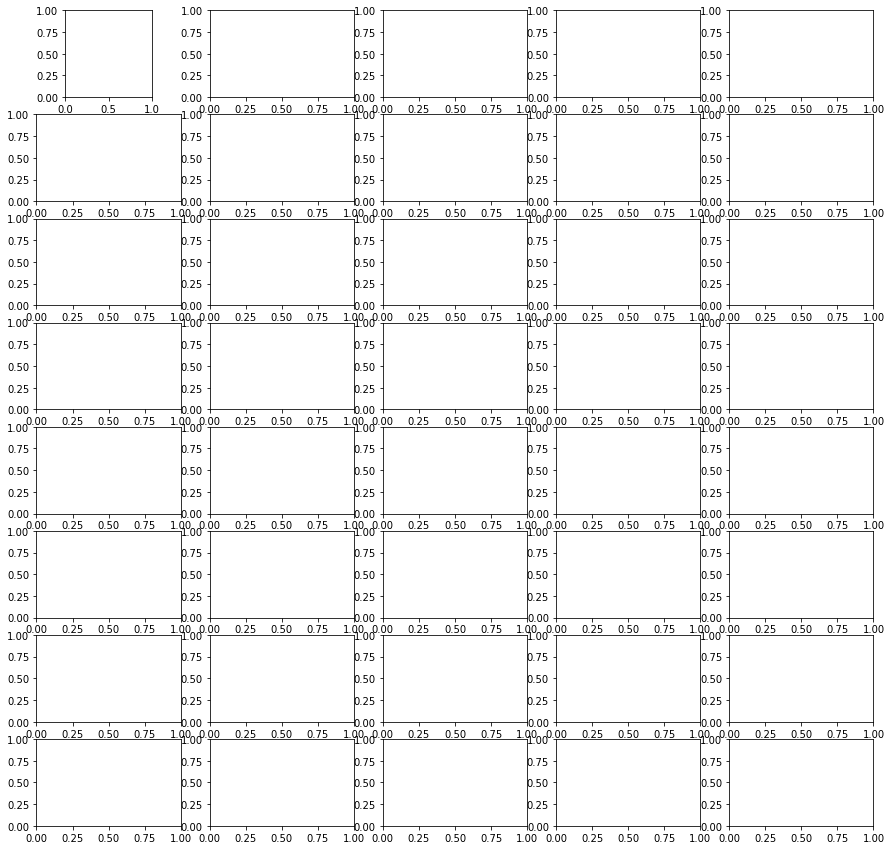

In [40]:
fig, ax = plt.subplots(8, 5)
fig.set_figheight(15)
fig.set_figwidth(15)
for i, axi in enumerate(ax.flat):
    axi.imshow(examples[i])
    axi.set(xticks=[], yticks=[],
            ylabel=names[target[i]])

Actually we need to flatten the images into 1d vectors so let's create that data set again

We need to flatten the images from 3D to 1D so we can use a random forest classifier. Essentially, just the pixel values, not their relative spatial position, are important for this algorithm 

In [41]:
## read in again, this time flattening
examples = []
for file in frames:
    with fs.open(file, 'rb') as f:
        examples.append(imresize(imread(f), (nx,ny,nz)).flatten())

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [42]:
np.shape(examples)

(51, 570312)

We want to classify each image into classes which are 'sites'. We'll create a numeric code for each sandbar site

What the code below does is assign a numeric class to every image. For example, the first 6 images are from site 0, the next 4 from site 1

In [43]:
d = {ni: indi for indi, ni in enumerate(set(names))}
target = sorted([d[ni] for ni in names])
target[:10]

[0, 0, 0, 0, 0, 0, 1, 1, 1, 1]

Now we'll use the utility function ```train_test_split``` provided by scikit-learn, to create a random split of test and train images

In [44]:
from sklearn.cross_validation import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(examples, target,
                                                random_state=42, test_size=0.3)
## this function splits our data into a training set and a testing set
# Xtrain is a subset of our data that we will train the model with
# Xtest is a subet of our data that we will validate with
# ytrain is the labels for the training dataset
# ytest is the labels of the validation dataset
# random_state = 42 sets a seed for the random number generator ensuring that you get the same random number as me
# test_size = 0.3 specifies that 30% of the dataset will be used for validation or testing while 70% is used for training

We have 35 training images, each consisting of 570312 features (pixels). We have 16 test images 

In [45]:
print(np.shape(Xtrain))
print(len(Xtest))

(35, 570312)
16


In [46]:
uniq_names = np.unique(names)
print(uniq_names)

['RC0025L' 'RC0081L' 'RC0089L' 'RC0166L' 'RC0220Ra' 'RC0235L' 'RC0307Rf'
 'RC0319R' 'RC0333L']


Ok, now we have a testing and training data set and labels. We're ready to start classifying

## Random forest

Random forests are an example of an ensemble learner built on decision trees. Decision trees are extremely intuitive ways to classify or label objects: you simply ask a series of questions designed to zero-in on the classification. 


#### Decision tree

In a well-constructed tree, each question will cut the number of options by approximately half, very quickly narrowing the options even among a large number of classes. The trick, of course, comes in deciding which questions to ask at each step. In machine learning implementations of decision trees, the questions generally take the form of axis-aligned splits in the data: that is, each node in the tree splits the data into two groups using a cutoff value within one of the features. 

![](https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.08-decision-tree.png)

***

In [47]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(np.squeeze(Xtrain), ytrain)

A simple decision tree built on this data will iteratively split the data along one or the other axis according to some quantitative criterion, and at each level assign the label of the new region according to a majority vote of points within it.

Let's write a quick utility function to help us visualize the output of the classifier

This function will take the training data (X: sandbar images) and the associated labels (y: sandbar site labels), and show the 'decision space' as shaded colored regions. Each color represents a different class

In [48]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200), # np.linspace() creates linearly spaced sequence of numbers
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)## .ravel() flattens arrays into one dimension

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5, # np.arange(n) creates a sequence of number from 0 to n
                                                                   # then 0.5 is subtracted from every item in the sequence and sored in 'levels'
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

Now we can examine what the decision tree classification looks like. We'll just use the first 2 features (columns) in X, which are just the first 2 pixels across all 35 images

In [49]:
Xim = np.squeeze(Xtrain)[:,:2] ## 'squeeze' removes singleton dimensions, ':2' means 'just the first 2 columns'
yim = np.asarray(ytrain)
print(np.shape(Xim))
print(np.shape(yim))

(35, 2)
(35,)


The plot below shows different sites as colored dots (there are 35 dots corresponding to 35 images), and the colored regions show the portion of that parameter space assigned to each class

/opt/conda/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'clim'
  s)


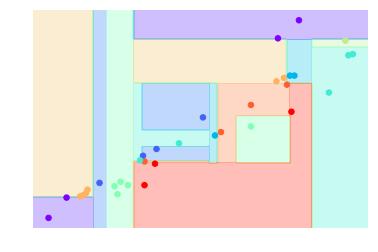

In [50]:
visualize_classifier(DecisionTreeClassifier(), Xim, yim)

In reality, this is done in 570312 dimensions at once, but I can only view 2 or 3 at a time

As we can see, our features are highly correlated and their choice is arbitrary, so we could use principal components (see lesson 2) to remove the redundancy in the data

In [51]:
from sklearn.decomposition import PCA
pca  =  PCA(n_components =2)
## fit to data
pca.fit(Xtrain)
## apply the transformation
images_pca = pca.transform(Xtrain)

/opt/conda/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'clim'
  s)


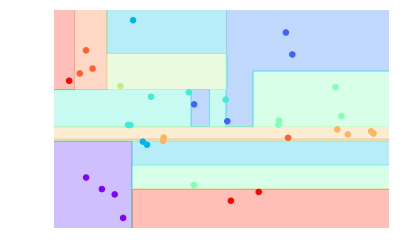

In [52]:
np.shape(images_pca)
visualize_classifier(DecisionTreeClassifier(), images_pca, yim)

Now we are going to fit the decision tree classifier to the entire (un-PCA'd) dataset (not just the first 2 features)

In [53]:
tree = DecisionTreeClassifier().fit(np.squeeze(Xtrain), ytrain)

In [54]:
## mean accuracy on the given test data and labels.
tree.score(np.squeeze(Xtest), ytest)

0.375

Fairly low. What if we use principal components to transform the imagery into features?

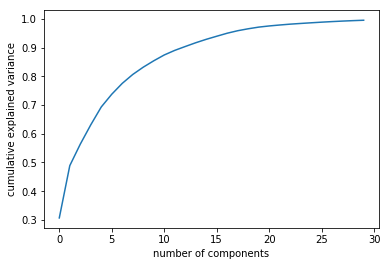

In [55]:
pca  =  PCA(n_components =30)
## fit to data
pca.fit(Xtrain)
## apply the transformation
images_pca = pca.transform(Xtrain)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

About 10 components explains ~90% of the variance. Let's use those

In [56]:
pca  =  PCA(n_components =10).fit(Xtrain)
## apply the transformation
images_pca = pca.transform(Xtrain)

# apply model to test data
tree = DecisionTreeClassifier().fit(images_pca, ytrain)
tree.score(pca.transform(Xtest), ytest)

0.75

Better accuracy. How does the Random Forest compare?

#### Random Forest

A random forest is a collection of decision trees that have been trained on randomly selected subsets of data.

They make predictions by returning the mean of the trees' predictions

They are less prone to overfitting because no single tree can learn from all the instances and explanatory variables

In [57]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=1000)
model.fit(np.squeeze(images_pca), ytrain)
ypred = model.predict(pca.transform(Xtest))           

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [59]:
model.score(pca.transform(Xtest), ytest)

0.8125

Better still. Why?

Decision trees suffer from over-fitting: it is very easy to go too deep in the tree, and thus to fit details of the particular data rather than the overall properties of the distributions they are drawn from.

The random forest – an ensemble of randomized decision trees - is a powerful method with several advantages:

* The multiple trees allow for a probabilistic classification: a majority vote among estimators gives an estimate of the probability (accessed in Scikit-Learn with the predict_proba() method).

* The nonparametric model is extremely flexible, and can thus perform well on tasks that are under-fit by other estimators.

Before we continue, let's dive into evaluation criteria a little deeper

### Accuracy statistics

Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced (unequal number of examples per class) 

#### Precision

is a measure of the fraction of the data that is correctly classified (positively). 

For example, the fraction of water pixels that are actually water

#### Recall (Sensitivity)

is a measure of the fraction of the data classes that are correctly identified. For example, the fraction of true water pixels that were detected

They are both useful because the classifier with impressive accuracy could actually fail to detect most water pixels

#### The F1 score 

is an equal weighting of the recall and precision and quantiﬁes how well the model performs in general.

It penalizes classifiers with imbalanced precision and recall scores

### FP/FN/TP/TN
A system with high recall but low precision returns many correct results, but most of its predicted labels are incorrect when compared to the training labels. 

A system with high precision but low recall is just the opposite, returning very few correct results, but most of its predicted labels are correct when compared to the training labels. 

True positives are image regions/pixels correctly classiﬁed as belonging to a certain class by the model, while true negatives are correctly classiﬁed as not belonging to a certain class. 

False negatives (Type 2 error) are regions/pixels incorrectly classiﬁed as not belonging to a certain class, and false positives (Type 1 error) are those regions/pixels incorrectly classiﬁed as belonging to a certain class. 

![](https://nlpforhackers.io/wp-content/uploads/2017/01/Precision-Recall.png)

#### Precision

Precision ($P$) is defined as the number of true positives ($T_p$) over the number of true positives plus the number of false positives ($F_p$).

$P = \frac{T_p}{T_p+F_p}$

#### Recall

Recall ($R$) is defined as the number of true positives ($T_p$) over the number of true positives plus the number of false negatives ($F_n$).

$R = \frac{T_p}{T_p + F_n}$

#### F1 score

These quantities are also related to the ($F_1$) score, which is defined as the harmonic mean of precision and recall.

$F1 = 2\frac{P \times R}{P+R}$

In [58]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00         2
          1       1.00      1.00      1.00         2
          2       0.67      1.00      0.80         2
          3       0.00      0.00      0.00         1
          4       1.00      1.00      1.00         1
          5       0.33      1.00      0.50         1
          6       0.00      0.00      0.00         2
          7       1.00      1.00      1.00         2
          8       1.00      1.00      1.00         3

avg / total       0.73      0.81      0.76        16



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Confusion matrix

A “confusion matrix”, which is the matrix of normalized correspondences between true and estimated labels, is a convenient way to visualize model skill. 

A perfect correspondence between true and estimated labels is scored 1.0 along the diagonal elements of the matrix. 

Misclassifications are readily identified as off-diagonal elements. Systematic misclassifications are recognized as off-diagonal elements with large magnitudes. 

In [60]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize: #normalization means scaling all row elements so each row sums to 1
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(10,10))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(shrink=0.75)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45) ## we rotate the tick labels so we can see them better
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd' ## this is a formating string that plots
    ## floating point (2 decimal places) if normalized values, or integers otherwise
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.axis('tight')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [61]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, ypred)
mat

array([[2, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 2, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 2, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 2, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 3]])

Confusion matrix, without normalization


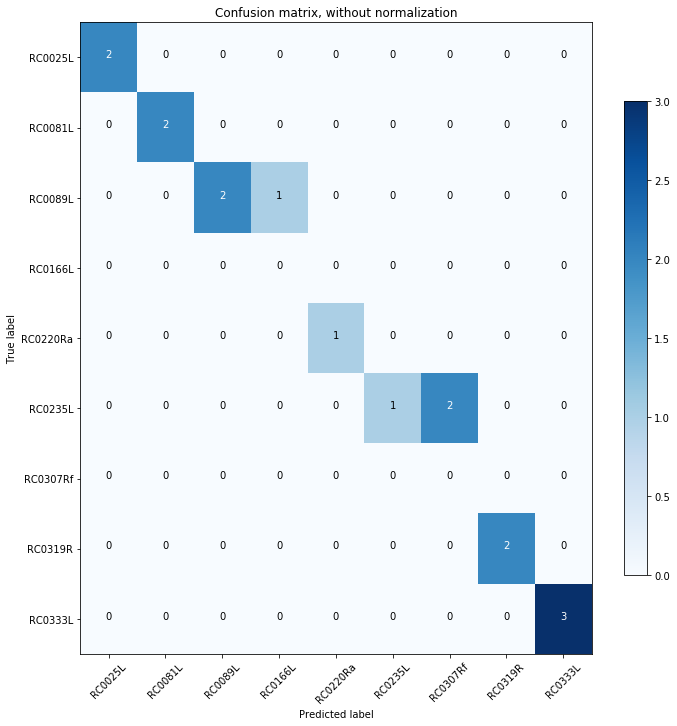

In [62]:
plot_confusion_matrix(mat, classes=uniq_names,
                      title='Confusion matrix, without normalization')

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


Normalized confusion matrix


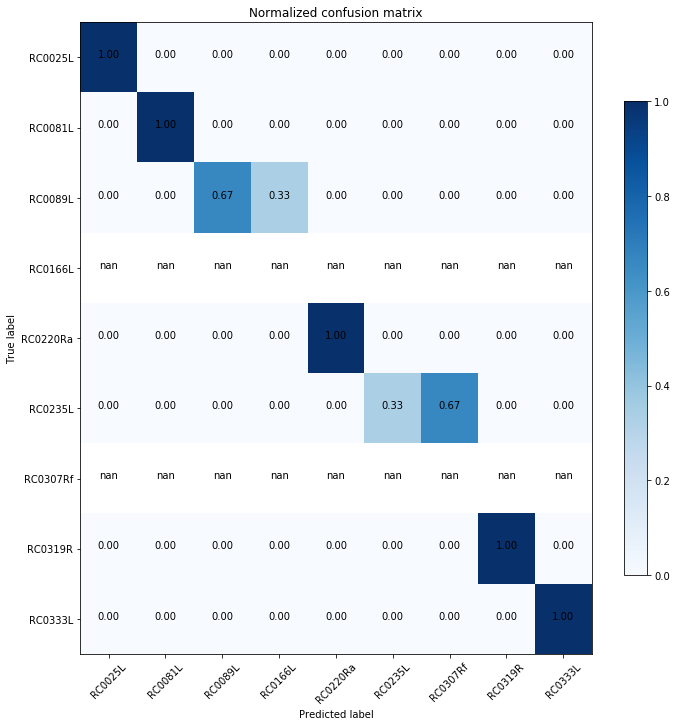

In [63]:
# Plot normalized confusion matrix
plot_confusion_matrix(mat, classes=uniq_names, normalize=True,
                      title='Normalized confusion matrix')

## Cross-validation

We hold back some subset of the data from the training of the model, and then use this holdout set to check the model performance

A sequence of fits where each subset of the data is used both as a training set and as a validation set.

Here we do two validation trials, alternately using each subset of the data as a holdout set. Using the split data from before, we could implement it like this:

In [64]:
y2_model = model.fit(pca.transform(Xtrain), ytrain).predict(pca.transform(Xtest))

In [65]:
y1_model = model.fit(pca.transform(Xtest), ytest).predict(pca.transform(Xtrain))

In [66]:
metrics.accuracy_score(ytrain, y1_model), metrics.accuracy_score(ytest, y2_model)

(0.5428571428571428, 0.8125)

What comes out are two accuracy scores, which we could combine (by, say, taking the mean) to get a better measure of the global model performance. This particular form of cross-validation is a two-fold cross-validation—that is, one in which we have split the data into two sets and used each in turn as a validation set.

We could expand on this idea to use even more trials, and more folds in the data

Here we split the data into five groups, and use each of them in turn to evaluate the model fit on the other 4/5 of the data. This would be rather tedious to do by hand, and so we can use Scikit-Learn's cross_val_score convenience routine to do it succinctly:

In [67]:
from sklearn.cross_validation import cross_val_score

# we are stacking the training and testing data so the training 2D arrays sits on top of the testing 2D array (vertical stack)
X = np.vstack((pca.transform(Xtrain), pca.transform(Xtest)))
print(np.shape(X))
# we are stacking the associated 'y' (label) vectors. Because these are both 1D, we use the 'hstack' command
y = np.hstack((ytrain, ytest))
print(np.shape(y))

(51, 10)
(51,)


In [68]:
### AN EXAMPLE OF np.hstack and np.vstack
##>>> np.vstack(([1,2,3],[4,5,6]))
##array([[1, 2, 3],
##       [4, 5, 6]])
##>>> np.column_stack(([1,2,3],[4,5,6]))
##array([[1, 4],
##       [2, 5],
##       [3, 6]])
##>>> np.hstack(([1,2,3],[4,5,6]))
##array([1, 2, 3, 4, 5, 6])

In [69]:
cross_val_score(model, X, y, cv=5)

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


array([0.9375    , 1.        , 0.88888889, 0.88888889, 1.        ])

Repeating the validation across different subsets of the data gives us an even better idea of the performance of the algorithm.

### Feature importances

Bagged decision trees like Random Forest and Extra Trees can be used to estimate the importance of features.

Fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting.

In [70]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(pca.transform(Xtrain), ytrain)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Text(0,0.5,'Relative Importance')

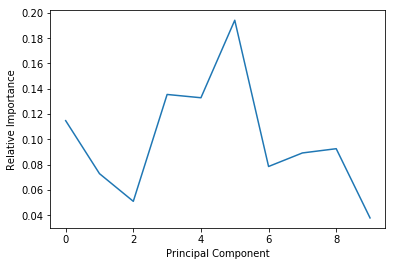

In [71]:
plt.plot(np.arange(10), model.feature_importances_)
plt.xlabel('Principal Component')
plt.ylabel('Relative Importance')

While the first principal component always explains the most amount of variance in the input data, it doesn't mean that principal component is necessarily the most important in the ML classifier, as is evidenced here

## Support vector machine

Support vector machines (SVMs) are a particularly powerful and flexible class of supervised algorithms for both classification and regression. In this section, we will develop the intuition behind support vector machines and their use in classification problems.

A linear discriminative classifier would attempt to draw a straight line separating the two sets of data, and thereby create a model for classification. 

Below, we create two-dimensional data again using 2 principal components

In [73]:
pca2  =  PCA(n_components =2)
## fit to data
pca2.fit(Xtrain)
## apply the transformation
images_pca2 = pca2.transform(Xtrain)

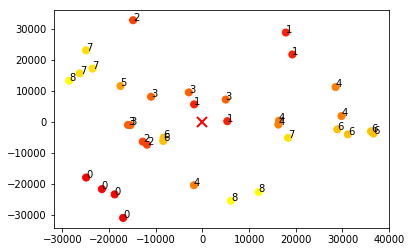

In [74]:
xfit = np.linspace(-30000, 30000)
plt.scatter(images_pca2[:, 0], images_pca2[:, 1], c=ytrain, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)
for lab in range(len(ytrain)):
    plt.text(images_pca2[lab, 0], images_pca2[lab, 1], str(ytrain[lab]))

You can see the clustering is there, but it is weak.

here we will use a principal component analysis to extract 10 fundamental components to feed into our support vector machine classifier. We can do this most straightforwardly by packaging the preprocessor and the classifier into a single pipeline:

In [75]:
pca  =  PCA(n_components =10)
## fit to data
pca.fit(Xtrain)
## apply the transformation
images_pca = pca.transform(Xtrain)

A 'pipeline' means to sequentially apply a list of transforms and a final estimator. Intermediate steps of the pipeline must be ‘transforms’, that is, they must implement fit and transform methods. The final estimator only needs to implement fit

Below, we 'pipe' the output of the PCA analysis into the SVC classifier

In [76]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA 
from sklearn.pipeline import make_pipeline

pcamodel = PCA(svd_solver='randomized', n_components=10, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pcamodel, svc)

When evaluating different settings (“hyperparameters”) for estimators, such as the C setting that must be manually set for an SVM, there is still a risk of overfitting on the test set because the parameters can be tweaked until the estimator performs optimally. 

This way, knowledge about the test set can “leak” into the model and evaluation metrics no longer report on generalization performance. 

To solve this problem, yet another part of the dataset can be held out as a so-called “validation set”: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set.

However, by partitioning the available data into three sets, we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.

A solution to this problem is a procedure called cross-validation (CV for short). A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV. In the basic approach, called k-fold CV, the training set is split into k smaller sets (other approaches are described below, but generally follow the same principles). The following procedure is followed for each of the k “folds”:

* A model is trained using k-1 of the folds as training data;

* the resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as accuracy).


The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. This approach can be computationally expensive, but does not waste too much data (as it is the case when fixing an arbitrary test set), which is a major advantage in problem such as inverse inference where the number of samples is very small.

In [77]:
from sklearn.grid_search import GridSearchCV

/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


We'll do a limited grid search consistig of a few different likely values for two hyperparameters 

In [78]:
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01]}
grid = GridSearchCV(model, param_grid)

In [79]:
%time grid.fit(images_pca, ytrain)

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


CPU times: user 908 ms, sys: 2.08 s, total: 2.98 s
Wall time: 757 ms


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=10, random_state=42,
  svd_solver='randomized', tol=0.0, whiten=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'svc__C': [1, 5, 10, 50], 'svc__gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [80]:
print(grid.best_params_)

{'svc__C': 5, 'svc__gamma': 0.005}


In [81]:
model = grid.best_estimator_
yfit = model.predict(pca.transform(Xtest))           
yfit

array([7, 6, 7, 2, 4, 5, 3, 6, 0, 5, 2, 1, 8, 1, 8, 0])

Let's plot a few images and their predictions

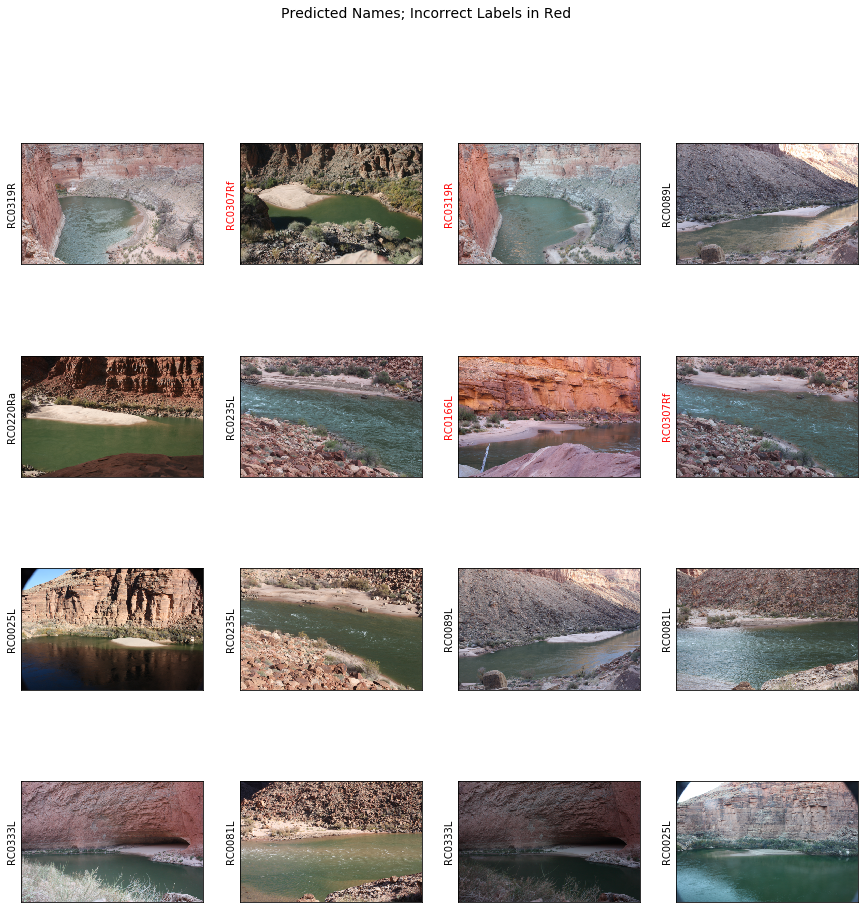

In [82]:
fig, ax = plt.subplots(4,4)
fig.set_figheight(15)
fig.set_figwidth(15)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(nx,ny,nz))
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(uniq_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

In [83]:
print(metrics.classification_report(ytest, ypred, target_names=uniq_names))

             precision    recall  f1-score   support

    RC0025L       1.00      1.00      1.00         2
    RC0081L       1.00      1.00      1.00         2
    RC0089L       1.00      0.67      0.80         3
    RC0166L       0.00      0.00      0.00         0
   RC0220Ra       1.00      1.00      1.00         1
    RC0235L       1.00      0.33      0.50         3
   RC0307Rf       0.00      0.00      0.00         0
    RC0319R       1.00      1.00      1.00         2
    RC0333L       1.00      1.00      1.00         3

avg / total       1.00      0.81      0.87        16



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [84]:
mat = confusion_matrix(ytest, yfit)

Confusion matrix, without normalization


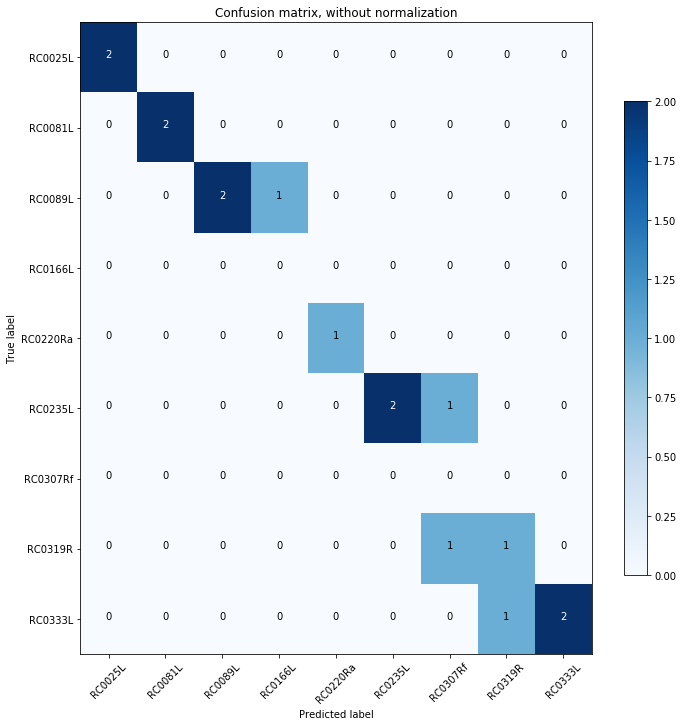

In [85]:
plot_confusion_matrix(mat, classes=uniq_names,
                      title='Confusion matrix, without normalization')

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


Normalized confusion matrix


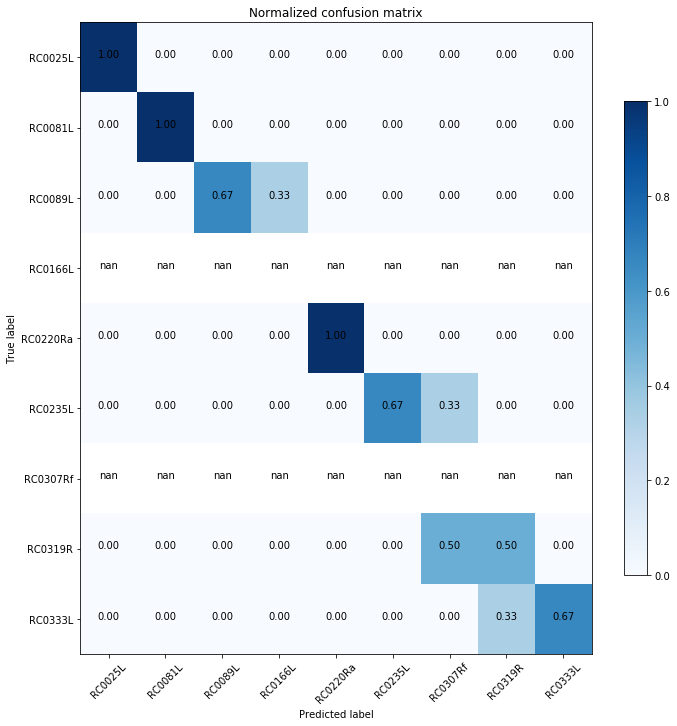

In [86]:
# Plot normalized confusion matrix
plot_confusion_matrix(mat, classes=uniq_names, normalize=True,
                      title='Normalized confusion matrix')


## Finding airplanes with HOG

Using HOG features, we can build up a simple image recognition algorithm with any Scikit-Learn estimator; here we will use a support vector machine.

The steps are as follows:

* Obtain a set of image thumbnails of airplanes to constitute "positive" training samples.
* Obtain a set of image thumbnails of non-airplanes to constitute "negative" training samples.
* Extract HOG features from these training samples.
* Train a SVM classifier on these samples.
* For an "unknown" image, pass a sliding window across the image, using the model to evaluate whether that window contains an airplane or not.

### Positive training samples

In [87]:
from skimage import feature, color

We need to build libraries of both positive (airplane) and negative (not airplane) examples

In [88]:
names = [f for f in fs.ls(root+'/imrecog_data/NWPU-RESISC45/train/airplane') if f.endswith('.jpg')]

positive_patches = []
for name in names:
    with fs.open(name, 'rb') as f:
        positive_patches.append(color.rgb2gray(imread(f, 'jpg')))

In [89]:
np.shape(positive_patches)

(350, 256, 256)

We have 350 airplane images to train on

### Negative training samples

In [90]:
fs.ls(root+'/imrecog_data/NWPU-RESISC45/test/')

['esipfed/cdi-workshop/imrecog_data/NWPU-RESISC45/test/airplane',
 'esipfed/cdi-workshop/imrecog_data/NWPU-RESISC45/test/airport',
 'esipfed/cdi-workshop/imrecog_data/NWPU-RESISC45/test/baseball_diamond',
 'esipfed/cdi-workshop/imrecog_data/NWPU-RESISC45/test/basketball_court',
 'esipfed/cdi-workshop/imrecog_data/NWPU-RESISC45/test/beach',
 'esipfed/cdi-workshop/imrecog_data/NWPU-RESISC45/test/bridge',
 'esipfed/cdi-workshop/imrecog_data/NWPU-RESISC45/test/chaparral',
 'esipfed/cdi-workshop/imrecog_data/NWPU-RESISC45/test/church',
 'esipfed/cdi-workshop/imrecog_data/NWPU-RESISC45/test/circular_farmland',
 'esipfed/cdi-workshop/imrecog_data/NWPU-RESISC45/test/cloud',
 'esipfed/cdi-workshop/imrecog_data/NWPU-RESISC45/test/commercial_area',
 'esipfed/cdi-workshop/imrecog_data/NWPU-RESISC45/test/dense_residential',
 'esipfed/cdi-workshop/imrecog_data/NWPU-RESISC45/test/desert',
 'esipfed/cdi-workshop/imrecog_data/NWPU-RESISC45/test/forest',
 'esipfed/cdi-workshop/imrecog_data/NWPU-RESISC45

In [91]:
names1 = [f for f in fs.ls(root+'/imrecog_data/NWPU-RESISC45/test/baseball_diamond') if f.endswith('.jpg')]
names2 = [f for f in fs.ls(root+'/imrecog_data/NWPU-RESISC45/test/airport') if f.endswith('.jpg')]
names = names1 + names2
len(names)

700

In [92]:
negative_patches = []
for name in names:
    with fs.open(name, 'rb') as f:
        negative_patches.append(color.rgb2gray(imread(f, 'jpg')))

Let's take a look at a few of them to get an idea of what they look like:

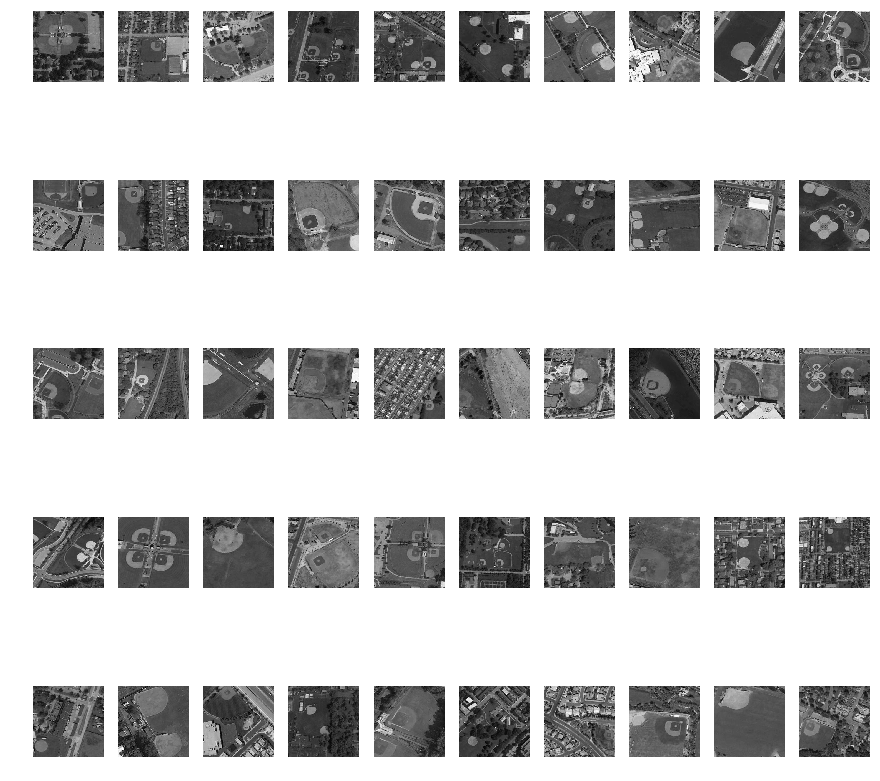

In [93]:
fig, ax = plt.subplots(5, 10)
fig.set_figheight(15)
fig.set_figwidth(15)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[i], cmap='gray')
    axi.axis('off')

### Combine and extract HOG features

Now that we have these positive samples and negative samples, we can combine them and compute HOG features. This step takes a little while, because the HOG features involve a nontrivial computation for each image:

In [94]:
from itertools import chain
X_train = np.array([feature.hog(im)
                    for im in chain(positive_patches,
                                    negative_patches)])

/opt/conda/lib/python3.6/site-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


In [95]:
nx, ny = np.shape(X_train)
y_train = np.zeros(nx)
y_train[:len(positive_patches)] = 1

In [96]:
X_train.shape

(1050, 72900)

We are left with 1050 training samples in 72,900 dimensions

### Training a support vector machine

First, let's use a simple Gaussian naive Bayes to get a quick baseline:

Naive Bayes classifiers are built on Bayesian classification methods. These rely on Bayes's theorem, which is an equation describing the relationship of conditional probabilities of statistical quantities. 

In Bayesian classification, we're interested in finding the probability of a label given some observed features, which we can write as $P(L~|~{\rm features})$. Bayes's theorem tells us how to express this in terms of quantities we can compute more directly:

$P(L~|~{\rm features}) = \frac{P({\rm features}~|~L)P(L)}{P({\rm features})}$

If we are trying to decide between two labels—let's call them $L_1$ and $L_2$—then one way to make this decision is to compute the ratio of the posterior probabilities for each label:

$$
\frac{P(L_1~|~{\rm features})}{P(L_2~|~{\rm features})} = \frac{P({\rm features}~|~L_1)}{P({\rm features}~|~L_2)}\frac{P(L_1)}{P(L_2)}
$$

All we need now is some model by which we can compute $P({\rm features}~|~L_i)$ for each label. 

Why "naive" Bayes? If we make very naive assumptions about the generative model for each label, we can find a rough approximation of the generative model for each class, and then proceed with the Bayesian classification. 

In a Gaussian NB model, the assumption is that data from each label is drawn from a simple Gaussian distribution

In [97]:
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import cross_val_score

cross_val_score(GaussianNB(), X_train, y_train)

array([0.62678063, 0.67142857, 0.59025788])

Accuracy is ~60%

For such a high-dimensional binary classification task, a Linear support vector machine is a good choice. We will use Scikit-Learn's LinearSVC, because in comparison to SVC it often has better scaling for large number of samples.

Let's try the support vector machine, with a grid search over a few choices of the C parameter:

In [98]:
from sklearn.svm import LinearSVC
from sklearn.grid_search import GridSearchCV
grid = GridSearchCV(LinearSVC(), {'C': [0.125, 0.25, 0.5, 1.0]})
grid.fit(X_train, y_train)
grid.best_score_

0.6733333333333333

Accuracy is 67%

In [99]:
grid.best_params_

{'C': 0.25}

In [100]:
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC(C=0.25, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

### Finding airplanes in new images

In [101]:
names = [f for f in fs.ls(root+'/imrecog_data/NWPU-RESISC45/test/airplane') if f.endswith('.jpg')]

We will use one image and run a sliding window over it and evaluate each patch:

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


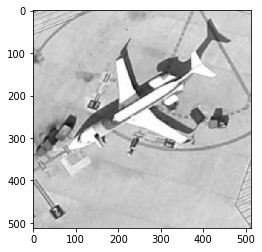

In [102]:
from skimage import transform
with fs.open(names[20], 'rb') as f:
    test_image = imread(f, 'jpg')
test_image = color.rgb2gray(test_image)
test_image = transform.rescale(test_image,2)
plt.imshow(test_image, cmap='gray')

Next, let's create a window that iterates over patches of this image, and compute HOG features for each patch:

In [103]:
def sliding_window(img, patch_size=positive_patches[0].shape,
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch

In [104]:
indices, patches = zip(*sliding_window(test_image, istep=32, jstep=32))
len(patches)

64

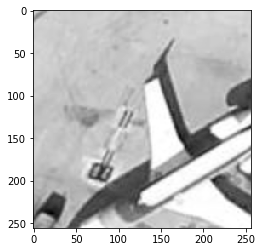

In [105]:
plt.imshow(patches[10], cmap='gray')

In [106]:
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

/opt/conda/lib/python3.6/site-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


(64, 72900)

Finally, we can take these HOG-featured patches and use our model to evaluate whether each patch contains an airplane:

In [107]:
labels = model.predict(patches_hog)
labels.sum()

25.0

We see that out of all the patches, we have found a few detections. Let's use the information we have about these patches to show where they lie on our test image, drawing them as rectangles:

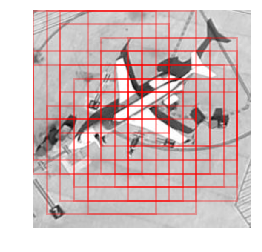

In [108]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))

We can view this in a different way by creating a "heatmap" of identification

In [109]:
heatmap = np.zeros(np.shape(test_image))

In [110]:
for i, j in indices[labels == 1]:
    heatmap[i:i+Ni, j:j+Nj] = heatmap[i:i+Ni, j:j+Nj]+1

(-0.5, 511.5, 511.5, -0.5)

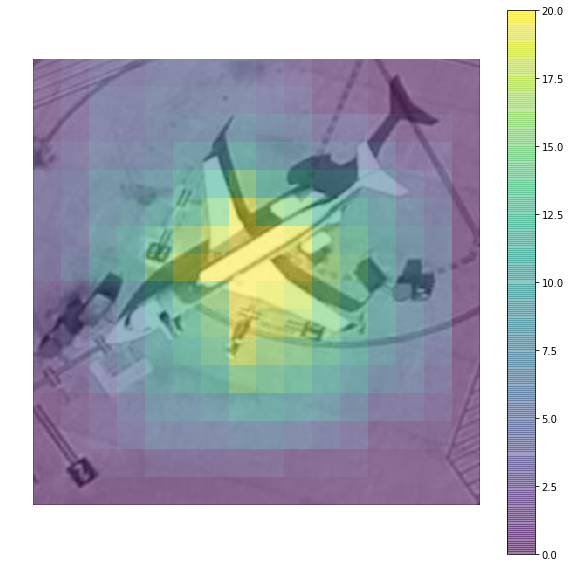

In [111]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
ax.imshow(test_image, cmap='gray')
plt.imshow(heatmap, alpha=0.5, vmax=20)
plt.colorbar()
ax.axis('off')

Let's test it on some "non-airplane" imagery

In [112]:
names = [f for f in fs.ls(root+'/imrecog_data/NWPU-RESISC45/test/lake') if f.endswith('.jpg')]

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


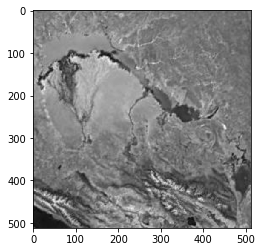

In [113]:
with fs.open(names[10], 'rb') as f:
    test_image = imread(f, 'jpg')
test_image = color.rgb2gray(test_image)
test_image = transform.rescale(test_image,2)
plt.imshow(test_image, cmap='gray')

In [114]:
indices, patches = zip(*sliding_window(test_image, istep=32, jstep=32))
patches_hog = np.array([feature.hog(patch) for patch in patches])

/opt/conda/lib/python3.6/site-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


In [115]:
labels = model.predict(patches_hog)
labels.sum()

2.0

In [116]:
heatmap = np.zeros(np.shape(test_image))

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    heatmap[i:i+Ni, j:j+Nj] = heatmap[i:i+Ni, j:j+Nj]+1

(-0.5, 511.5, 511.5, -0.5)

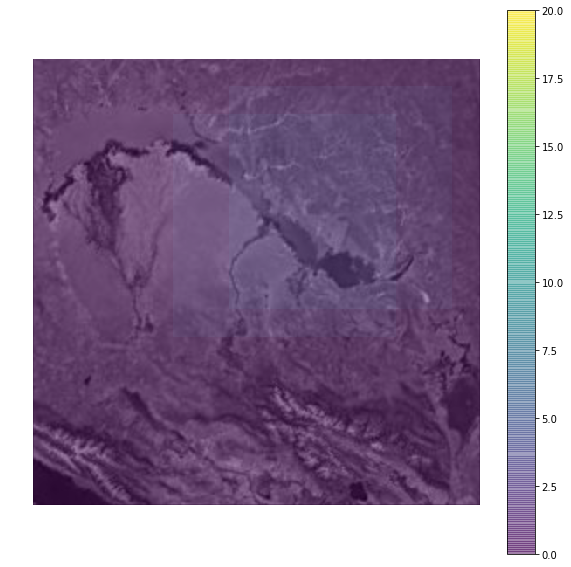

In [117]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
ax.imshow(test_image, cmap='gray')
plt.imshow(heatmap, alpha=0.5, vmax=20)
plt.colorbar()
ax.axis('off')

## Exercises

1. Tuning a random forest model
2. Classifying plankton

### 1. Tuning a random forest model with respect to the number of features to consider

From ```RandomForestClassifier?```

max_features : int, float, string or None, optional (default="auto")
    The number of features to consider when looking for the best split:

    - If int, then consider `max_features` features at each split.
    - If float, then `max_features` is a percentage and
      `int(max_features * n_features)` features are considered at each
      split.
    - If "auto", then `max_features=sqrt(n_features)`.
    - If "sqrt", then `max_features=sqrt(n_features)` (same as "auto").
    - If "log2", then `max_features=log2(n_features)`.
    - If None, then `max_features=n_features`.

Using the sandbars dataset that we prepared earlier 
(training data = ```images_pca``` and ```ytrain```, testing data = ``pca.transform(Xtest)`` and ```ytest```)

1. Create a list of max_features options
2. In a loop ...
    * cycle through each option
    * ```fit``` the model to the training data
    * ```predict``` labels for the testing data
    * evaluate the accuracy of the prediction
3. Plot the results - which choice yields most accuracy?   

### 2. Classifying plankton

Train a classifier to classify plankton images

This is a large data set, so be careful how much of it you use.

For example, we could load up to the first 100 images from just the first 10 categories of plankton

In [ ]:
import os
cats = [f for f in fs.ls(root+'/imrecog_data/plankton/train')]
train_names = []
train_labels = []
for cat in cats[:10]:
    f = [f for f in fs.ls(cat) if f.endswith('.jpg')][:100]
    train_names.extend(f)
    train_labels.extend([cat.split(os.sep)[-1] for i in range(len(f))])

In [ ]:
print(len(train_labels))
train_labels[0]

For testing, we could sample the last 10 images 

In [ ]:
test_names = []
test_labels = []
for cat in cats[:10]:
    f = [f for f in fs.ls(cat) if f.endswith('.jpg')][-10:]
    test_names.extend(f)
    test_labels.extend([cat.split(os.sep)[-1] for i in range(len(f))])
print(len(test_labels))    

Ok, now come up with a classifier!

(note: the images are different sizes)